In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import seaborn as sns

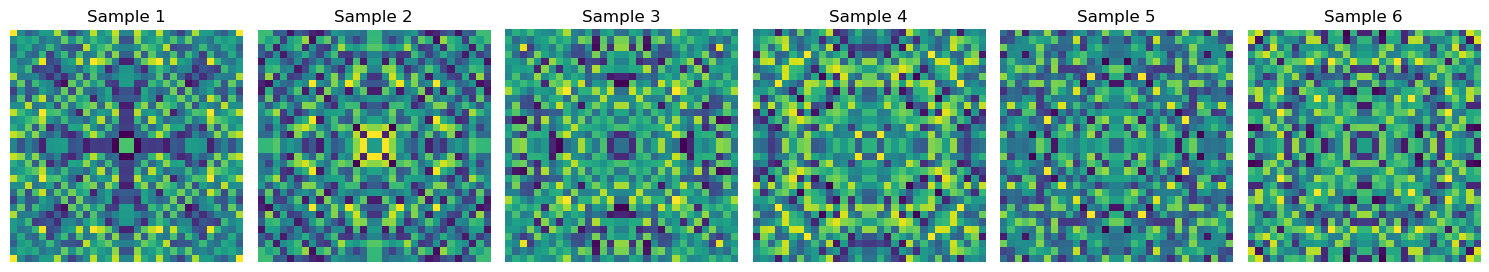

In [6]:
def generate_8fold_symmetric_images(n_images, size=32):
    """
    Generate n_images of size x size with 8-fold symmetry and pixel values 0-1
    
    Args:
        n_images (int): Number of images to generate
        size (int): Size of each image (size x size pixels)
    
    Returns:
        np.ndarray: Array of shape (n_images, size, size) containing the symmetric images
    """
    # Only generate 1/8 of the image, then reflect/rotate for symmetry
    sector_size = size // 2
    sector = np.random.rand(n_images, sector_size, sector_size)
    
    # Create full images
    images = np.zeros((n_images, size, size))
    
    for i in range(n_images):
        # Create base quadrant
        quadrant = np.concatenate([sector[i], np.fliplr(sector[i])], axis=1)
        
        # Create full image with 4-fold symmetry
        full = np.concatenate([quadrant, np.flipud(quadrant)], axis=0)
        
        # Add diagonal symmetry by averaging with transpose
        symmetric = (full + full.T) / 2
        
        images[i] = symmetric
        
    return images

# Generate example images
n_samples = 6
symmetric_images = generate_8fold_symmetric_images(n_samples)

# Visualize some examples
fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(symmetric_images[i], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Sample {i+1}')
plt.tight_layout()
plt.show()


C:\Users\zhang\AppData\Local\Temp\ipykernel_8408\1179357256.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


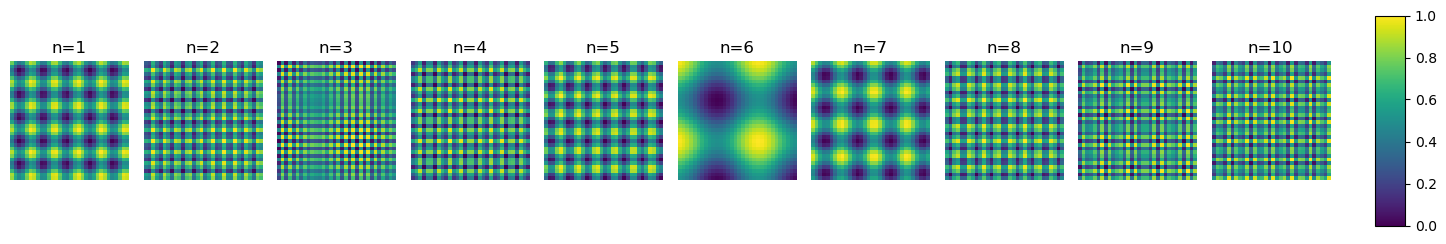

C:\Users\zhang\AppData\Local\Temp\ipykernel_8408\1179357256.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


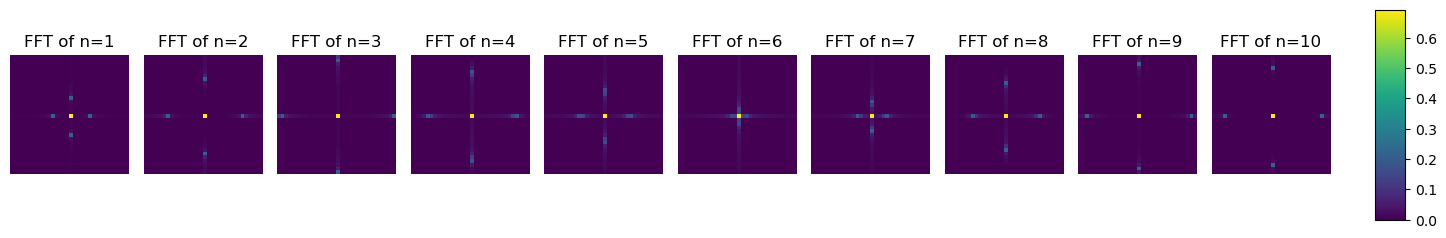

In [27]:
# Create list of integers
integers = list(range(1, 11))

def embed_integer_fourier(n, size=32):
    """
    Embed an integer as a size x size image using Fourier embedding
    
    Args:
        n (int): Integer to embed
        size (int): Size of output image (default 32)
    
    Returns:
        np.ndarray: size x size image embedding of the integer
    """
    # Create coordinate grid from 0 to 31
    x = np.arange(size)
    y = np.arange(size)
    X, Y = np.meshgrid(x, y)
    
    # Create pattern using cosine product with x+1 and y+1
    scalar = n
    pattern = (np.cos((Y+1)*scalar) + np.cos((X+1)*scalar))/2
    
    # Normalize to 0-1 range
    pattern = (pattern - pattern.min()) / (pattern.max() - pattern.min())
    
    return pattern

# Generate embeddings for each integer
fourier_embeddings = np.array([embed_integer_fourier(n) for n in integers])

# Visualize the embeddings
fig, axes = plt.subplots(1, len(integers), figsize=(15, 3), gridspec_kw={'width_ratios': [1]*len(integers)})
images = []
for i, ax in enumerate(axes):
    im = ax.imshow(fourier_embeddings[i], cmap='viridis')
    images.append(im)
    ax.axis('off')
    ax.set_title(f'n={integers[i]}')
# Add colorbar in a way that doesn't overlap with the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

# Compute and visualize the Fourier transforms of the embeddings
fourier_transforms = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) for embedding in fourier_embeddings])

# Normalize the Fourier transforms for better visualization
fourier_transforms = np.array([(ft - ft.min()) / (ft.max() - ft.min()) for ft in fourier_transforms])

# Plot the Fourier transforms
fig, axes = plt.subplots(1, len(integers), figsize=(15, 3), gridspec_kw={'width_ratios': [1]*len(integers)})
images = []
for i, ax in enumerate(axes):
    im = ax.imshow(np.log1p(fourier_transforms[i]), cmap='viridis')  # log scale for better visibility
    images.append(im)
    ax.axis('off') 
    ax.set_title(f'FFT of n={integers[i]}')
# Add colorbar in a way that doesn't overlap with the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

C:\Users\zhang\AppData\Local\Temp\ipykernel_8408\1199761066.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


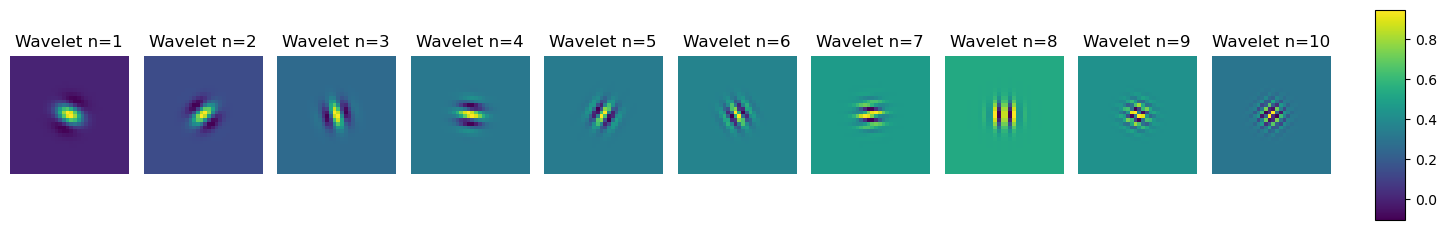

C:\Users\zhang\AppData\Local\Temp\ipykernel_8408\1199761066.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


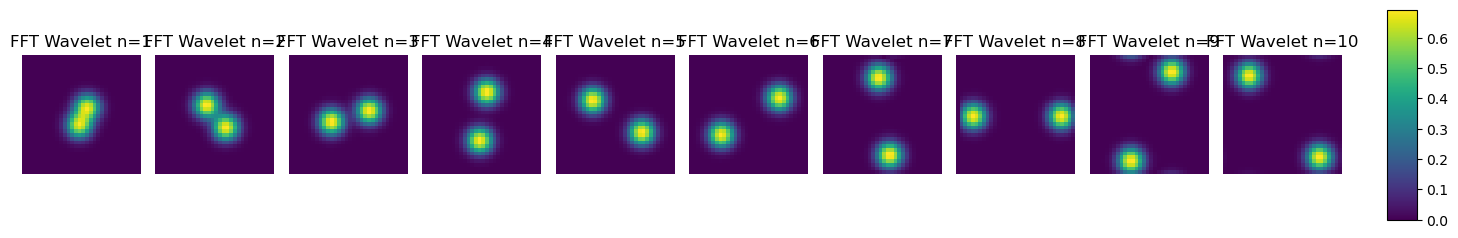

In [37]:
def embed_integer_wavelet(s, size=32, freq_range=2.0):
    """
    Embed an integer into a 2D pattern using Gabor wavelets.
    
    Args:
        s: Integer to embed
        size: Size of the square output array
        freq_range: Factor to control the frequency range (higher values = broader frequency range)
    
    Returns:
        2D numpy array with the Gabor wavelet embedding
    """
    # Create coordinate grid
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    
    # Set base frequency based on input scalar s
    # Use size as the fundamental frequency unit instead of pi
    base_frequency = (1.0 + abs(s)) * (size/8)
    
    # Set orientation (in radians)
    theta = s % 8 * (size/16)  # Vary orientation based on s
    
    # Rotate coordinates
    X_theta = X * np.cos(theta) + Y * np.sin(theta)
    Y_theta = -X * np.sin(theta) + Y * np.cos(theta)
    
    # Gaussian envelope parameters - inversely related to freq_range
    # Higher freq_range means smaller sigma which creates broader frequency spectrum
    sigma_x = 0.3 / freq_range
    sigma_y = 0.3 / freq_range
    
    # Gaussian envelope - smaller sigma creates a more localized wavelet in space
    # which corresponds to a broader frequency spectrum in Fourier domain
    gaussian = np.exp(-(X_theta**2 / (2 * sigma_x**2) + Y_theta**2 / (2 * sigma_y**2)))
    
    # Gabor wavelet (sinusoidal carrier * gaussian envelope)
    gabor = gaussian * np.cos(base_frequency * X_theta)
    
    # Return the pattern without normalizing to preserve values
    return gabor

# Generate wavelet embeddings for each integer
wavelet_embeddings = np.array([embed_integer_wavelet(s) for s in integers])

# Visualize the wavelet embeddings
fig, axes = plt.subplots(1, len(integers), figsize=(15, 3), gridspec_kw={'width_ratios': [1]*len(integers)})
images = []
for i, ax in enumerate(axes):
    im = ax.imshow(wavelet_embeddings[i], cmap='viridis')
    images.append(im)
    ax.axis('off')
    ax.set_title(f'Wavelet n={integers[i]}')
# Add colorbar in a way that doesn't overlap with the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

# Compute and visualize the Fourier transforms of the wavelet embeddings
wavelet_fourier = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) for embedding in wavelet_embeddings])

# Normalize the Fourier transforms for better visualization
wavelet_fourier = np.array([(ft - ft.min()) / (ft.max() - ft.min()) for ft in wavelet_fourier])

# Plot the Fourier transforms of wavelet embeddings
fig, axes = plt.subplots(1, len(integers), figsize=(15, 3), gridspec_kw={'width_ratios': [1]*len(integers)})
images = []
for i, ax in enumerate(axes):
    im = ax.imshow(np.log1p(wavelet_fourier[i]), cmap='viridis')  # log scale for better visibility
    images.append(im)
    ax.axis('off') 
    ax.set_title(f'FFT Wavelet n={integers[i]}')
# Add colorbar in a way that doesn't overlap with the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()



C:\Users\zhang\AppData\Local\Temp\ipykernel_8408\4262831768.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


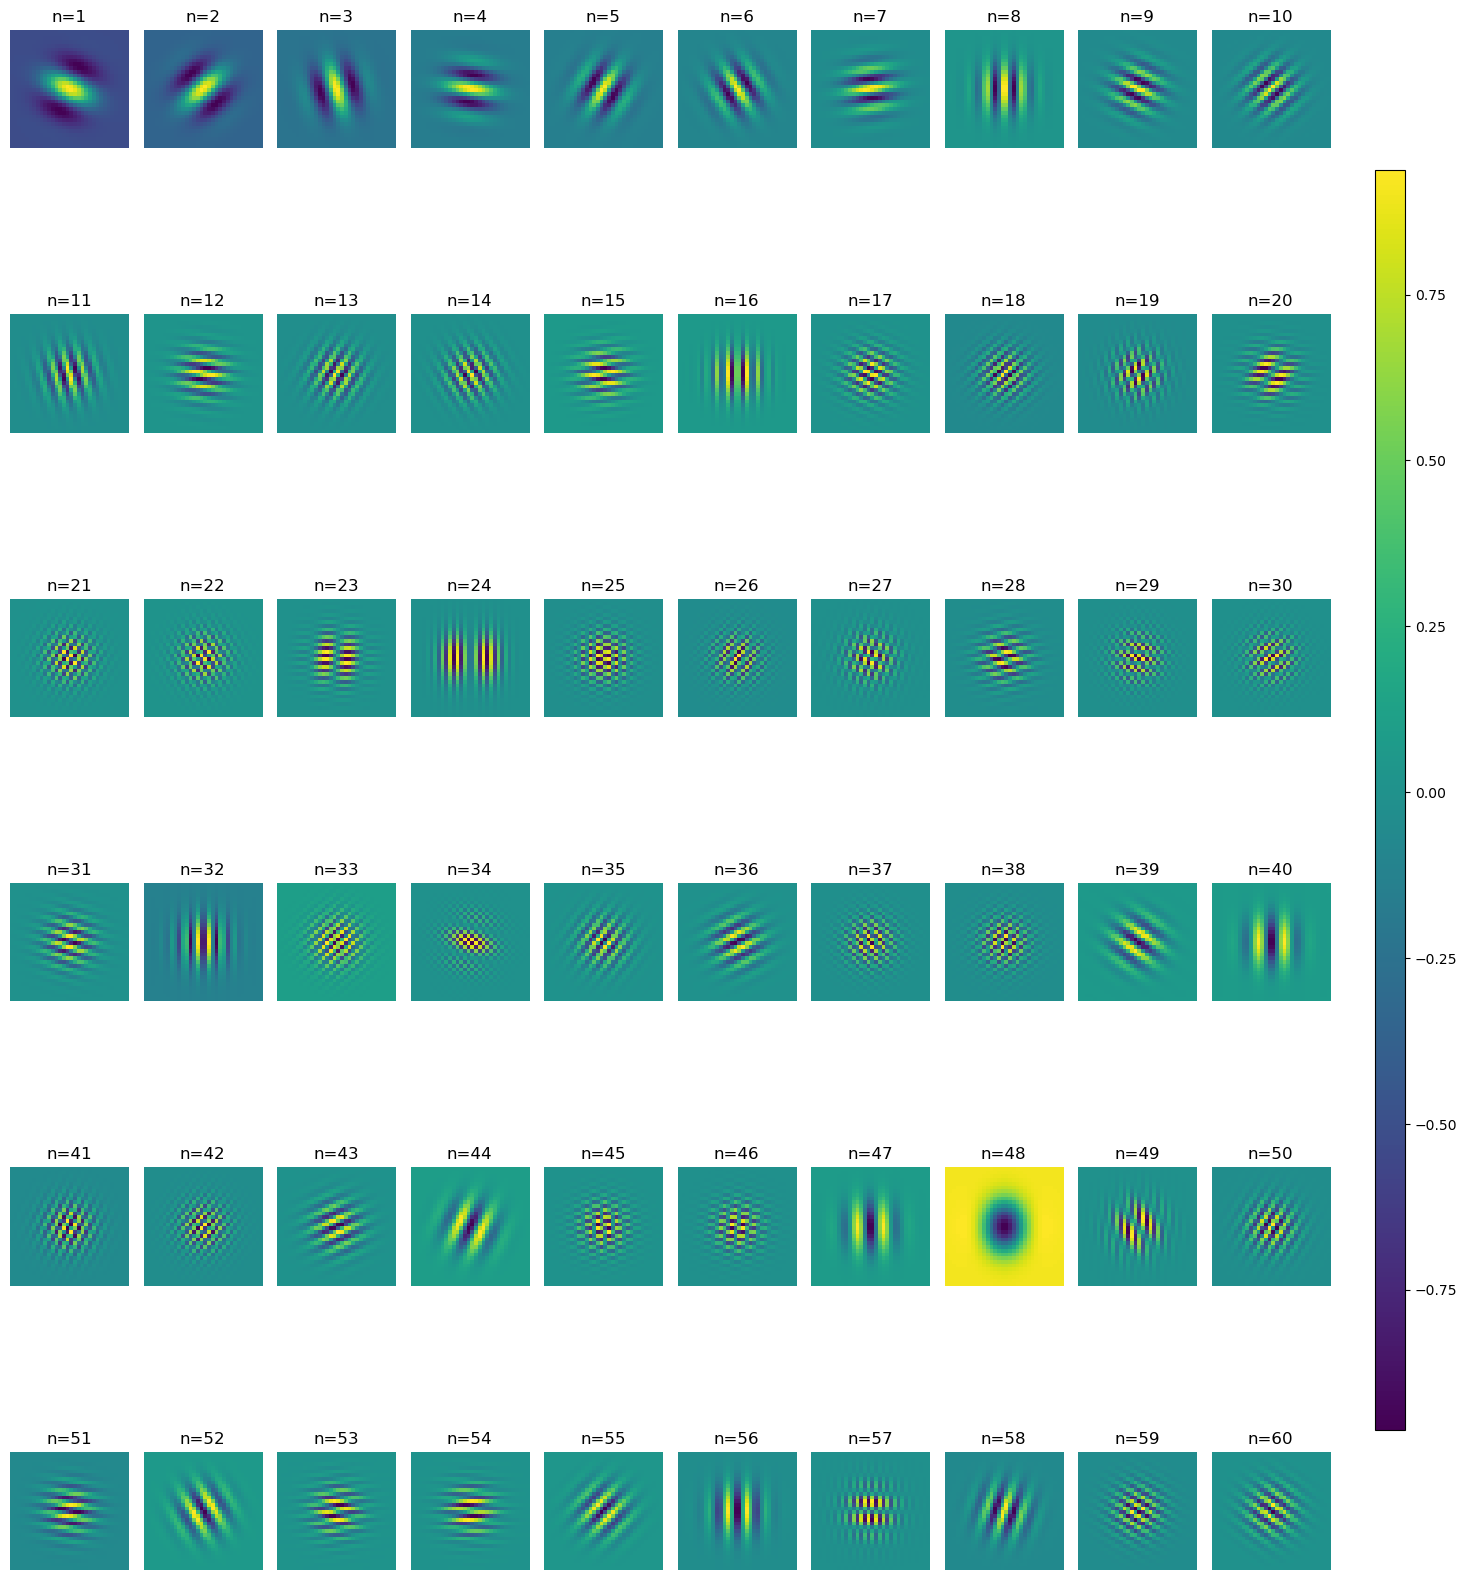

C:\Users\zhang\AppData\Local\Temp\ipykernel_8408\4262831768.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


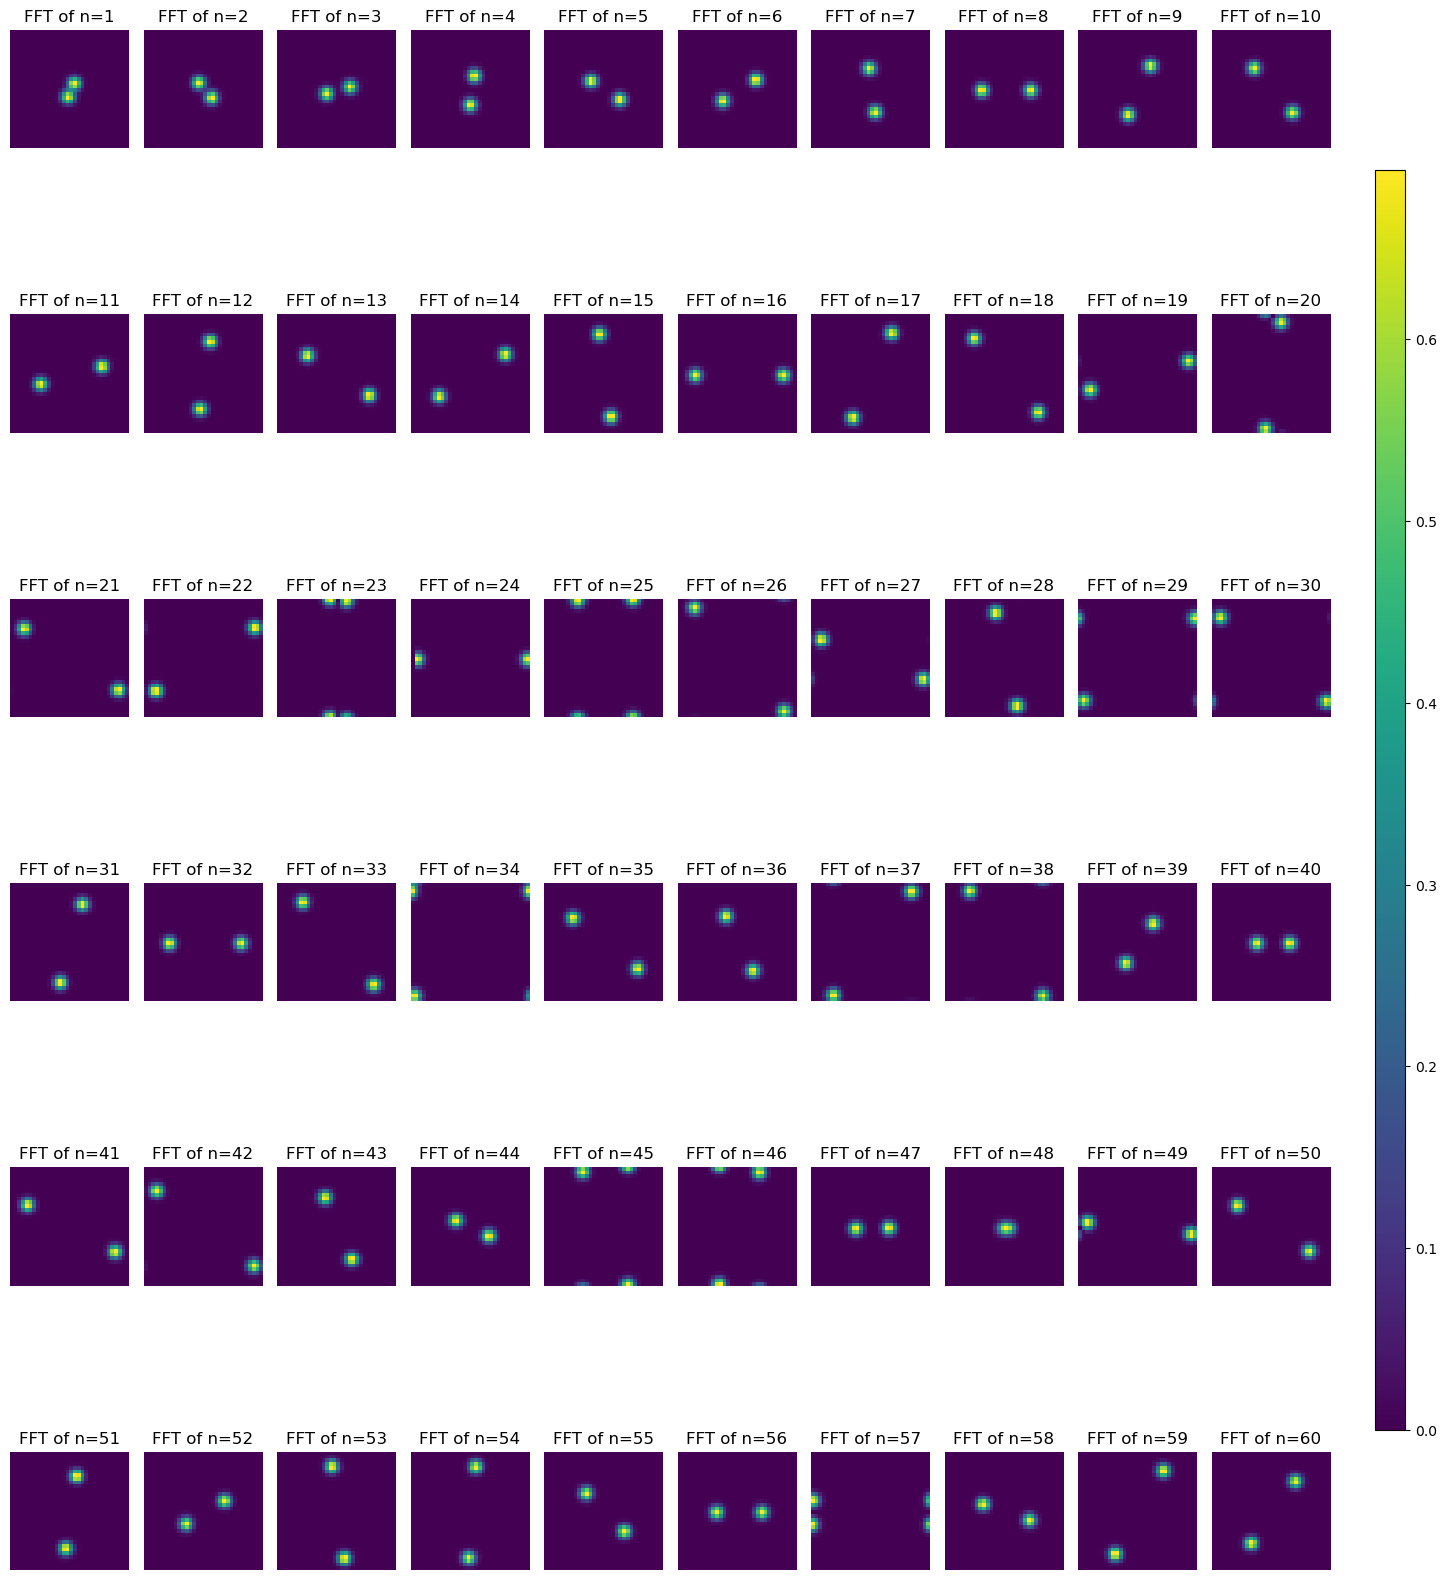

Wavelet Embeddings (Time Domain) Statistics:
Integer 1: Min = -0.2998, Max = 0.9840
Integer 2: Min = -0.4704, Max = 0.9882
Integer 3: Min = -0.6009, Max = 0.9648
Integer 4: Min = -0.6886, Max = 0.9362
Integer 5: Min = -0.7488, Max = 0.9797
Integer 6: Min = -0.8143, Max = 0.9761
Integer 7: Min = -0.8456, Max = 0.8907
Integer 8: Min = -0.8574, Max = 0.7898
Integer 9: Min = -0.8555, Max = 0.9286
Integer 10: Min = -0.8931, Max = 0.9854
Integer 11: Min = -0.9009, Max = 0.9389
Integer 12: Min = -0.8992, Max = 0.8365
Integer 13: Min = -0.9287, Max = 0.9485
Integer 14: Min = -0.9435, Max = 0.9392
Integer 15: Min = -0.9433, Max = 0.8122
Integer 16: Min = -0.8891, Max = 0.7645
Integer 17: Min = -0.8995, Max = 0.8634
Integer 18: Min = -0.8816, Max = 0.9798
Integer 19: Min = -0.8756, Max = 0.9310
Integer 20: Min = -0.8209, Max = 0.8158
Integer 21: Min = -0.9224, Max = 0.8953
Integer 22: Min = -0.9425, Max = 0.8937
Integer 23: Min = -0.7781, Max = 0.7607
Integer 24: Min = -0.5098, Max = 0.5085
Inte

In [31]:
# Generate a 6x10 subplot of wavelet embeddings for integers 1-60
integers_extended = np.arange(1, 61)  # Integers from 1 to 60

# Generate wavelet embeddings for each integer
wavelet_embeddings_extended = np.array([embed_integer_wavelet(s) for s in integers_extended])

# Create a 6x10 grid of subplots for wavelet embeddings
fig, axes = plt.subplots(6, 10, figsize=(15, 18))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each wavelet embedding
for i, ax in enumerate(axes):
    im = ax.imshow(wavelet_embeddings_extended[i], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'n={integers_extended[i]}')

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

# Compute the Fourier transforms of the wavelet embeddings
wavelet_fourier_extended = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) 
                                     for embedding in wavelet_embeddings_extended])

# Normalize the Fourier transforms for better visualization
wavelet_fourier_extended = np.array([(ft - ft.min()) / (ft.max() - ft.min()) 
                                     for ft in wavelet_fourier_extended])

# Create a 6x10 grid of subplots for FFT of wavelet embeddings
fig, axes = plt.subplots(6, 10, figsize=(15, 18))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each FFT
for i, ax in enumerate(axes):
    im = ax.imshow(np.log1p(wavelet_fourier_extended[i]), cmap='viridis')  # log scale for better visibility
    ax.axis('off')
    ax.set_title(f'FFT of n={integers_extended[i]}')

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

# Calculate and print the min and max values for both time and frequency domain representations
print("Wavelet Embeddings (Time Domain) Statistics:")
for i, embedding in enumerate(wavelet_embeddings_extended):
    print(f"Integer {integers_extended[i]}: Min = {embedding.min():.4f}, Max = {embedding.max():.4f}")

print("\nWavelet Fourier Transforms (Frequency Domain) Statistics:")
# Using the original Fourier transforms before normalization
wavelet_fourier_raw = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) 
                               for embedding in wavelet_embeddings_extended])
for i, ft in enumerate(wavelet_fourier_raw):
    print(f"Integer {integers_extended[i]}: Min = {ft.min():.4f}, Max = {ft.max():.4f}")

# Summary statistics
print("\nSummary Statistics:")
print(f"Time Domain - Overall Min: {wavelet_embeddings_extended.min():.4f}, Overall Max: {wavelet_embeddings_extended.max():.4f}")
print(f"Frequency Domain - Overall Min: {wavelet_fourier_raw.min():.4f}, Overall Max: {wavelet_fourier_raw.max():.4f}")


Calculating cross-correlation for 60 embeddings...

Highest cross-correlation found between:
Integer 40 and Integer 47
Correlation value: 0.997840


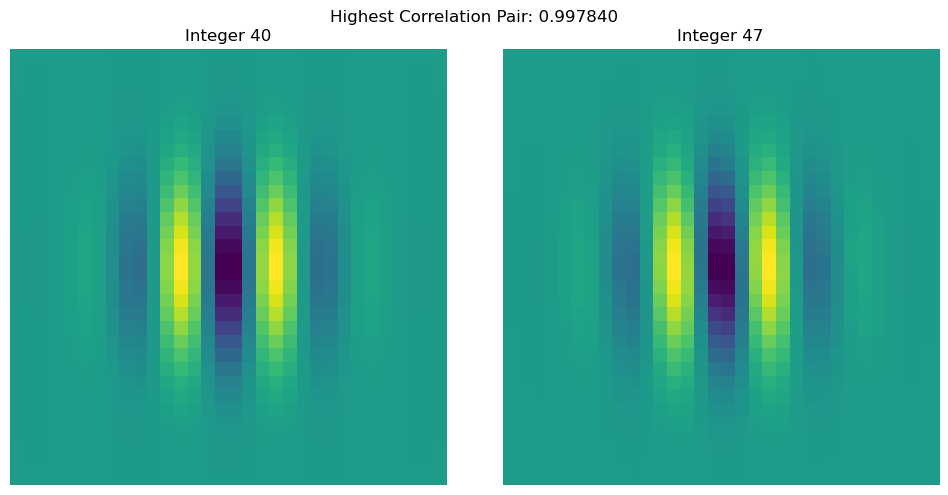

In [32]:
# Calculate cross-correlation between all pairs of wavelet embeddings
import itertools
from scipy import signal

# Get the number of embeddings
n_embeddings = len(wavelet_embeddings_extended)
print(f"Calculating cross-correlation for {n_embeddings} embeddings...")

# Initialize variables to track the highest correlation
highest_corr = 0
highest_pair = (0, 0)

# Iterate through all unique pairs
for i, j in itertools.combinations(range(n_embeddings), 2):
    # Calculate the 2D cross-correlation
    corr = signal.correlate2d(
        wavelet_embeddings_extended[i], 
        wavelet_embeddings_extended[j], 
        mode='same'
    )
    
    # Get the maximum correlation value
    max_corr = np.max(corr)
    
    # Normalize by the autocorrelations
    auto_corr_i = np.max(signal.correlate2d(
        wavelet_embeddings_extended[i], 
        wavelet_embeddings_extended[i], 
        mode='same'
    ))
    auto_corr_j = np.max(signal.correlate2d(
        wavelet_embeddings_extended[j], 
        wavelet_embeddings_extended[j], 
        mode='same'
    ))
    
    normalized_corr = max_corr / np.sqrt(auto_corr_i * auto_corr_j)
    
    # Update if this is the highest correlation so far
    if normalized_corr > highest_corr:
        highest_corr = normalized_corr
        highest_pair = (i, j)

# Print the results
print(f"\nHighest cross-correlation found between:")
print(f"Integer {integers_extended[highest_pair[0]]} and Integer {integers_extended[highest_pair[1]]}")
print(f"Correlation value: {highest_corr:.6f}")

# Visualize the two embeddings with highest correlation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first embedding
axes[0].imshow(wavelet_embeddings_extended[highest_pair[0]], cmap='viridis')
axes[0].set_title(f'Integer {integers_extended[highest_pair[0]]}')
axes[0].axis('off')

# Plot the second embedding
axes[1].imshow(wavelet_embeddings_extended[highest_pair[1]], cmap='viridis')
axes[1].set_title(f'Integer {integers_extended[highest_pair[1]]}')
axes[1].axis('off')

plt.suptitle(f'Highest Correlation Pair: {highest_corr:.6f}')
plt.tight_layout()
plt.show()


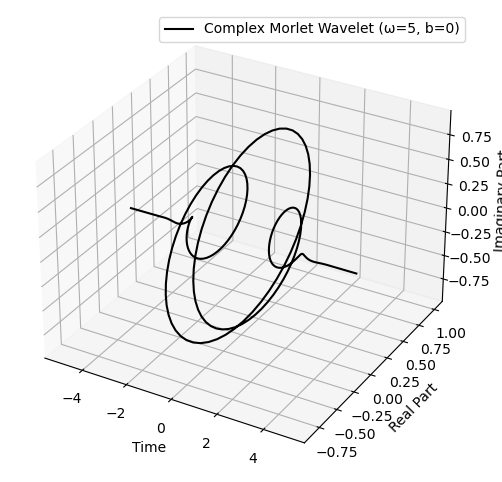

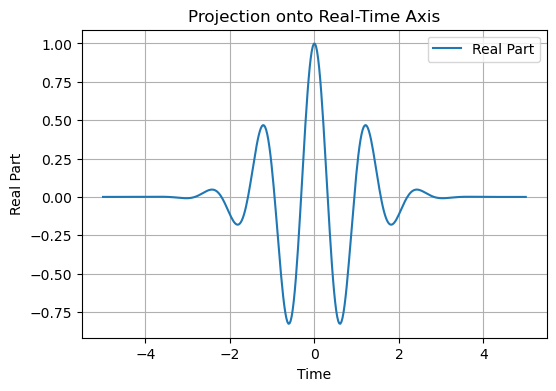

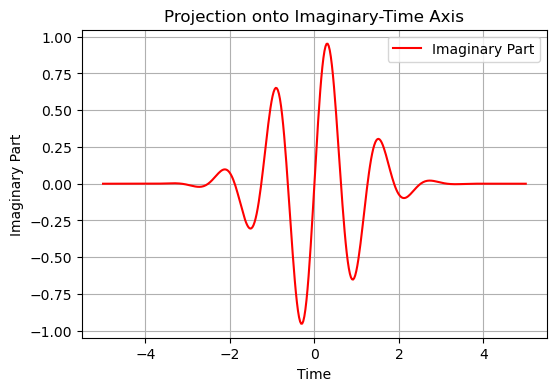

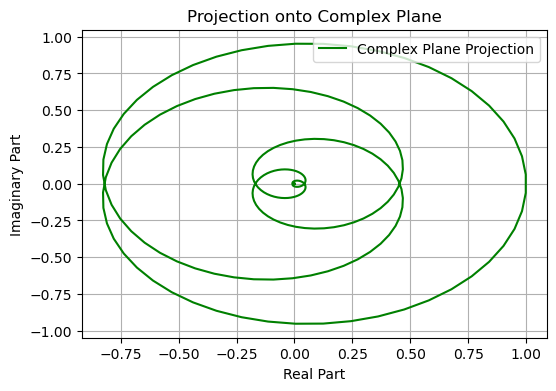

In [25]:
def morlet_wavelet(t, omega=5, b=0):
    return np.exp(1j * omega * (t - b)) * np.exp(-0.5 * (t - b) ** 2)

def plot_morlet_3d(omega=5, b=0):
    t = np.linspace(-5, 5, 400)
    wavelet = morlet_wavelet(t, omega, b)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(t, np.real(wavelet), np.imag(wavelet), label=f'Complex Morlet Wavelet (ω={omega}, b={b})', color='k')
    ax.set_xlabel('Time')
    ax.set_ylabel('Real Part')
    ax.set_zlabel('Imaginary Part')
    ax.legend()
    
    plt.show()

def plot_real_projection(omega=5, b=0):
    t = np.linspace(-5, 5, 400)
    wavelet = morlet_wavelet(t, omega, b)
    
    plt.figure(figsize=(6, 4))
    plt.plot(t, np.real(wavelet), label='Real Part')
    plt.xlabel('Time')
    plt.ylabel('Real Part')
    plt.title('Projection onto Real-Time Axis')
    plt.legend()
    plt.grid()
    plt.show()

def plot_imag_projection(omega=5, b=0):
    t = np.linspace(-5, 5, 400)
    wavelet = morlet_wavelet(t, omega, b)
    
    plt.figure(figsize=(6, 4))
    plt.plot(t, np.imag(wavelet), label='Imaginary Part', color='r')
    plt.xlabel('Time')
    plt.ylabel('Imaginary Part')
    plt.title('Projection onto Imaginary-Time Axis')
    plt.legend()
    plt.grid()
    plt.show()

def plot_complex_plane_projection(omega=5, b=0):
    t = np.linspace(-5, 5, 400)
    wavelet = morlet_wavelet(t, omega, b)
    
    plt.figure(figsize=(6, 4))
    plt.plot(np.real(wavelet), np.imag(wavelet), label='Complex Plane Projection', color='g')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Projection onto Complex Plane')
    plt.legend()
    plt.grid()
    plt.show()

# Example call with default values
plot_morlet_3d()
plot_real_projection()
plot_imag_projection()
plot_complex_plane_projection()
